# 前処理大全 SQL+Python版 (Chapter8)

## はじめに
- データベースはPostgreSQL13です
- 初めに以下のセルを実行してください
- セルに %%sql と記載することでSQLを発行することができます
- jupyterからはdescribeコマンドによるテーブル構造の確認ができないため、テーブル構造を確認する場合はlimitを指定したSELECTなどで代用してください
- 使い慣れたSQLクライアントを使っても問題ありません（接続情報は以下の通り）
  - IPアドレス：Docker Desktopの場合はlocalhost、Docker toolboxの場合は192.168.99.100
  - Port:5432
  - database名: dsdojo_db
  - ユーザ名：padawan
  - パスワード:padawan12345
- 大量出力を行うとJupyterが固まることがあるため、出力件数は制限することを推奨します（設問にも出力件数を記載）
    - 結果確認のために表示させる量を適切にコントロールし、作業を軽快にすすめる技術もデータ加工には求められます
- 大量結果が出力された場合は、ファイルが重くなり以降開けなくなることもあります
    - その場合、作業結果は消えますがファイルをGitHubから取り直してください
    - vimエディタなどで大量出力範囲を削除することもできます
- 名前、住所等はダミーデータであり、実在するものではありません

In [1]:
%load_ext sql
import os

pgconfig = {
    'host': 'db',
    'port': os.environ['PG_PORT'],
    'database': os.environ['PG_DATABASE'],
    'user': os.environ['PG_USER'],
    'password': os.environ['PG_PASSWORD'],
}
dsl = 'postgresql://{user}:{password}@{host}:{port}/{database}'.format(**pgconfig)

# MagicコマンドでSQLを書くための設定
%sql $dsl

'Connected: padawan@dsdojo_db'

In [2]:
import pandas as pd
import numpy as np
from scipy.sparse import csc_matrix
customer_df = pd.read_csv("./data/customer.csv")
reserve_df = pd.read_csv("./data/reserve.csv")
production_df = pd.read_csv("./data/production.csv")
production_missin_df = pd.read_csv("./data/production_missing_num.csv")

# 演習問題

### 008_number_type/001: 数値型への変換

#### SQL (Awesome)

* 数値はbyte数を示す。

In [3]:
%%sql
SELECT
    CAST( (40000.0 / 3) AS INT2 ) AS v_int2
    ,CAST( (40000.0 / 3) AS INT4 ) AS v_int4
    ,CAST( (40000.0 / 3) AS INT8 ) AS v_int8
    ,CAST( (40000.0 / 3) AS FLOAT4 ) AS v_float4
    ,CAST( (40000.0 / 3) AS FLOAT8 ) AS v_float8
FROM
    reserve_tb
LIMIT 1

 * postgresql://padawan:***@db:5432/dsdojo_db
1 rows affected.


v_int2,v_int4,v_int8,v_float4,v_float8
13333,13333,13333,13333.333,13333.333333333332


#### Python (Awesome)

* まあこれはちょっと何が説明したいのか書籍の方はよくわからなかったな。
* とりあえず、DataFrameの各列の型はastypeで変換できる。

In [4]:
type(40000 / 3)
int(40000 / 3)
float(40000 / 3)

df = pd.DataFrame({'value': [4000 / 3]})
df.dtypes

df['value'].astype('int8')
df['value'].astype('int16')
df['value'].astype('int32')
df['value'].astype('int64')

df['value'].astype('float16')
df['value'].astype('float32')
df['value'].astype('float64')
df['value'].astype('float128')

0    1333.333333
Name: value, dtype: float128

### 008_number_type/002: 対数化

* 線形モデルについての解説と対数化の必要性について
* 対数化する際は、元の値を0より大きくしておく必要がある。
* また+1を足して対数化する場合もおおい。+1をすることにより、対数化後の値が0以上となる。
* 値の絶対値が大きいほど差の意味を小さくしたい時などに有効。
  * 年収500万のひとは+100万でうれしいけど、年収1億のひとは+100万はちょっとうれしい。

#### SQL (Awesome)

* LOGは底10である。

In [5]:
%%sql
SELECT
    *
    ,LOG(total_price / 1000 + 1) AS total_price_log
FROM
    reserve_tb
LIMIT 5

 * postgresql://padawan:***@db:5432/dsdojo_db
5 rows affected.


reserve_id,hotel_id,customer_id,reserve_datetime,checkin_date,checkin_time,checkout_date,people_num,total_price,total_price_log
r1,h_75,c_1,2016-03-06 13:09:42,2016-03-26,10:00:00,2016-03-29,4,97200,1.9912260756924949
r2,h_219,c_1,2016-07-16 23:39:55,2016-07-20,11:30:00,2016-07-21,2,20600,1.3222192947339193
r3,h_179,c_1,2016-09-24 10:03:17,2016-10-19,09:00:00,2016-10-22,2,33600,1.5314789170422551
r4,h_214,c_1,2017-03-08 03:20:10,2017-03-29,11:00:00,2017-03-30,4,194400,2.290034611362518
r5,h_16,c_1,2017-09-05 19:50:37,2017-09-22,10:30:00,2017-09-23,3,68100,1.8388490907372552


#### Python (Awesome)

In [6]:
reserve_df['total_price_log'] = \
    reserve_df['total_price'].apply(lambda x: np.log10(x / 1000 + 1))
reserve_df.head(5)

,reserve_id,hotel_id,customer_id,reserve_datetime,checkin_date,checkin_time,checkout_date,people_num,total_price,total_price_log
0,r1,h_75,c_1,2016-03-06 13:09:42,2016-03-26,10:00:00,2016-03-29,4,97200,1.992111
1,r2,h_219,c_1,2016-07-16 23:39:55,2016-07-20,11:30:00,2016-07-21,2,20600,1.334454
2,r3,h_179,c_1,2016-09-24 10:03:17,2016-10-19,09:00:00,2016-10-22,2,33600,1.539076
3,r4,h_214,c_1,2017-03-08 03:20:10,2017-03-29,11:00:00,2017-03-30,4,194400,2.290925
4,r5,h_16,c_1,2017-09-05 19:50:37,2017-09-22,10:30:00,2017-09-23,3,68100,1.839478


### 008_number_type/003: 数値のカテゴリ化

* 年齢をある単位でカテゴリ化するなど

#### Python (Awesome)

* FLOORは切り捨ての関数
* 特定の関数で表現が難しいカテゴリ化はCASE文などを使う必要がある。

In [7]:
%%sql
select
    *,FLOOR(age / 10) * 10 as age_rank
from customer_tb
limit 5

 * postgresql://padawan:***@db:5432/dsdojo_db
5 rows affected.


customer_id,age,sex,home_latitude,home_longitude,age_rank
c_1,41,man,35.092193,136.512347,40.0
c_2,38,man,35.325076,139.410551,30.0
c_3,49,woman,35.120543,136.511179,40.0
c_4,43,man,43.034868,141.240314,40.0
c_5,31,man,35.102661,136.523797,30.0


#### Python (Awesome)

* `astype('category')`によりpandasのCategory型に変換する。

In [8]:
customer_df['age_rank'] = \
    (np.floor(customer_df['age'] / 10) * 10).astype('category')
customer_df.head(10)

,customer_id,age,sex,home_latitude,home_longitude,age_rank
0,c_1,41,man,35.092193,136.512347,40.0
1,c_2,38,man,35.325076,139.410551,30.0
2,c_3,49,woman,35.120543,136.511179,40.0
3,c_4,43,man,43.034868,141.240314,40.0
4,c_5,31,man,35.102661,136.523797,30.0
5,c_6,52,man,34.440768,135.390487,50.0
6,c_7,50,man,43.015758,141.231321,50.0
7,c_8,65,woman,38.201268,140.465961,60.0
8,c_9,36,woman,33.322800,130.330689,30.0
9,c_10,34,woman,34.290414,132.302601,30.0


### 008_number_type/004: 正規化

* 正規化が必要な理由
  * 正則化を適切に適用させるため
  * クラスタリングなどによりデータの類似性をノルムなどで表現するケース
* 正規化の種類
  * Standarization
  * Min-Max

#### Python (Awesome)

In [9]:
from sklearn.preprocessing import StandardScaler

df = reserve_df.copy()
df['people_num'] = df['people_num'].astype(float) # float変換

ss = StandardScaler()

result = ss.fit_transform(df[['people_num', 'total_price']])
df['people_num_normalized'] = [ x[0] for x in result ]
df['total_price_normalized'] = [ x[1] for x in result ]
df.head(5)

,reserve_id,hotel_id,customer_id,reserve_datetime,checkin_date,checkin_time,checkout_date,people_num,total_price,total_price_log,people_num_normalized,total_price_normalized
0,r1,h_75,c_1,2016-03-06 13:09:42,2016-03-26,10:00:00,2016-03-29,4.0,97200,1.992111,1.300709,-0.053194
1,r2,h_219,c_1,2016-07-16 23:39:55,2016-07-20,11:30:00,2016-07-21,2.0,20600,1.334454,-0.483753,-0.747822
2,r3,h_179,c_1,2016-09-24 10:03:17,2016-10-19,09:00:00,2016-10-22,2.0,33600,1.539076,-0.483753,-0.629935
3,r4,h_214,c_1,2017-03-08 03:20:10,2017-03-29,11:00:00,2017-03-30,4.0,194400,2.290925,1.300709,0.828240
4,r5,h_16,c_1,2017-09-05 19:50:37,2017-09-22,10:30:00,2017-09-23,3.0,68100,1.839478,0.408478,-0.317080


### 008_number_type/005: 外れ値除去

* 色々あるが大きなテーマなので、一般的に用いられる正規分布ベースのものを紹介する。
  * 標準偏差の3倍を除去する。これにより統計的に99.73%のものが残り、0.27%が除去される。
* また検討するためには可視化することも有効な手段。


#### Python (Awesome)

In [10]:
reserve_df[
    (reserve_df['total_price'] - reserve_df['total_price'].mean()).abs() / reserve_df['total_price'].std() <= 3
].reset_index(drop=True).head(5)

,reserve_id,hotel_id,customer_id,reserve_datetime,checkin_date,checkin_time,checkout_date,people_num,total_price,total_price_log
0,r1,h_75,c_1,2016-03-06 13:09:42,2016-03-26,10:00:00,2016-03-29,4,97200,1.992111
1,r2,h_219,c_1,2016-07-16 23:39:55,2016-07-20,11:30:00,2016-07-21,2,20600,1.334454
2,r3,h_179,c_1,2016-09-24 10:03:17,2016-10-19,09:00:00,2016-10-22,2,33600,1.539076
3,r4,h_214,c_1,2017-03-08 03:20:10,2017-03-29,11:00:00,2017-03-30,4,194400,2.290925
4,r5,h_16,c_1,2017-09-05 19:50:37,2017-09-22,10:30:00,2017-09-23,3,68100,1.839478


### 008_number_type/006: 主成分分析による次元圧縮

* 主成分分析では、情報損失が最も少なくなるように、圧縮後の次元の分散が最大化する変換を行う。
* 元のデータをどの程度うまく説明しているかを寄与率で表現する。
* 寄与率の合計（累積寄与率）が9割以上となるような次元数を採用することが多い。
* 次元削減で精度が上がることは筆者の経験上少ない。
* 線形モデルであれば、多重共線性という変数間に強い相関がある場合に過学習してしまう問題があり、それを防止可能だが、これは正則化でも防ぐことができる。
* むしろわかりやすいくするための可視化などに用いるイメージが強い。

#### Python (Awesome)

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

pca_results = pca.fit_transform(production_df[['length', 'thickness']])

print(f"累積寄与率: {sum(pca.explained_variance_ratio_)}")
print(f"各次元の寄与率: {pca.explained_variance_ratio_}")

累積寄与率: 1.0
各次元の寄与率: [0.97897794 0.02102206]


### 008_number_type/007: 数値型の補完

* 欠損はおおきく３種類に分かれる
  * MAR(Missing Completely at Random): 完全なランダム欠損
  * MAR(Missing at Random): 何か別の項目に影響されて欠損する確率が高くなる欠損
  * MNAR(Missing not at Random): その項目自身の値の絶対値等に影響されて欠損する確率が高くなる欠損
* 保管方法
  * 欠損が多い場合は非推奨
    * 任意の定数による補完
    * 集計値による補完（平均・中央・最大・最小）
  * 欠損していないデータに基づく予測（機械学習など）
  * 時系列からの補完
    * 欠損周囲の値の平均など
  * 多重代入法
    * 特定の値を代入したデータセットを複数作成して解析をする
  * 最尤法
    * 本来のデータばらつきよりも補完後のばらつきが小さくなる問題を解消する。
    * 機械学習ではなく、潜在変数を導入し、EMアルゴリズムを用いて尤度を最大化することで、欠損値を推定する。

### 008_number_type/007a: 欠損値の削除

#### SQL (Awesome)

In [12]:
%%sql
select
    *
from production_missin_tb
where thickness is not null

 * postgresql://padawan:***@db:5432/dsdojo_db
(psycopg2.errors.UndefinedTable) リレーション"production_missin_tb"は存在しません
LINE 3: from production_missin_tb
             ^

[SQL: select
    *
from production_missin_tb
where thickness is not null]
(Background on this error at: https://sqlalche.me/e/14/f405)


#### Python (Awesome)

* dropnaはNoneを欠損値として扱わないので注意する。
* subsetを指定しない場合、すべての列についての欠損値有無を確認する。
* デフォルトはレコードを削除するが、axis=1をすると列を削除する。

In [13]:
df = production_missin_df.replace('None', np.nan)
df = production_missin_df.dropna(subset=['thickness'])
df

,type,length,thickness,fault_flg
0,E,274.027383,40.24113135955541,False
1,D,86.319269,16.906714630016268,False
2,E,123.940388,1.0184619943950775,False
3,B,175.554886,16.41492419553766,False
4,B,244.934740,29.061080805480326,False
...,...,...,...,...
995,C,363.214163,48.36948254254505,False
996,D,134.773797,26.861665493072845,False
997,B,231.174985,7.087471454014727,False
998,D,81.613510,5.716271403731385,False


### 008_number_type/007b: 欠損値の定数置き換え

#### SQL (Awesome)

* COALESCEを使用する。

In [14]:
%%sql
SELECT
    type
    ,length
    ,COALESCE(thickness, 1) as thickness
    ,fault_flg
from
    work.pruduction_missn_tb

 * postgresql://padawan:***@db:5432/dsdojo_db
(psycopg2.errors.UndefinedTable) リレーション"work.pruduction_missn_tb"は存在しません
LINE 7:     work.pruduction_missn_tb
            ^

[SQL: SELECT
    type
    ,length
    ,COALESCE(thickness, 1) as thickness
    ,fault_flg
from
    work.pruduction_missn_tb]
(Background on this error at: https://sqlalche.me/e/14/f405)


#### Python (Awesome)

* fillnaを使用する。
* subsetとか使えないので注意。

In [15]:
df = production_missin_df.replace('None', np.nan)
df['thickness'] = df['thickness'].fillna(1)
df

,type,length,thickness,fault_flg
0,E,274.027383,40.24113135955541,False
1,D,86.319269,16.906714630016268,False
2,E,123.940388,1.0184619943950775,False
3,B,175.554886,16.41492419553766,False
4,B,244.934740,29.061080805480326,False
...,...,...,...,...
995,C,363.214163,48.36948254254505,False
996,D,134.773797,26.861665493072845,False
997,B,231.174985,7.087471454014727,False
998,D,81.613510,5.716271403731385,False


### 008_number_type/007c: 欠損値の平均値定数置き換え

#### SQL (Awesome)

* COALESCEにAVGを組み合わせる。
* AVG計算に欠損は考慮されない？？

In [16]:
%%sql
SELECT
    type
    ,length
    ,COALESCE(thickness, (select AVG(thickness) from work.production_missn_tb)
        ) as thickness
    ,fault_flg
from
    work.pruduction_missn_tb

 * postgresql://padawan:***@db:5432/dsdojo_db
(psycopg2.errors.UndefinedTable) リレーション"work.pruduction_missn_tb"は存在しません
LINE 8:     work.pruduction_missn_tb
            ^

[SQL: SELECT
    type
    ,length
    ,COALESCE(thickness, (select AVG(thickness) from work.production_missn_tb)
        ) as thickness
    ,fault_flg
from
    work.pruduction_missn_tb]
(Background on this error at: https://sqlalche.me/e/14/f405)


#### Python (Awesome)

* fillnaを使用する。
* 欠損値が含まれる列はObject型になっているため、一旦数値型に変換する。

In [17]:
df = production_missin_df.replace('None', np.nan)

df['thickness'] = df['thickness'].astype('float64')
thickness_mean = df['thickness'].mean()
df['thickness'] = df['thickness'].fillna(thickness_mean)
df

,type,length,thickness,fault_flg
0,E,274.027383,40.241131,False
1,D,86.319269,16.906715,False
2,E,123.940388,1.018462,False
3,B,175.554886,16.414924,False
4,B,244.934740,29.061081,False
...,...,...,...,...
995,C,363.214163,48.369483,False
996,D,134.773797,26.861665,False
997,B,231.174985,7.087471,False
998,D,81.613510,5.716271,False


### 008_number_type/007d: PMMによる多重代入法

#### Python (Awesome)

* fancyimputeという聞きなれないライブラリを使う。

In [18]:
!pip install fancyimpute

     |████████████████████████████████| 2.8 MB 7.3 MB/s eta 0:00:01
     |████████████████████████████████| 12.7 MB 10.4 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 10.7 MB/s eta 0:00:01
     |████████████████████████████████| 154 kB 10.1 MB/s eta 0:00:01
     |████████████████████████████████| 189 kB 9.6 MB/s eta 0:00:01
     |████████████████████████████████| 10.7 MB 10.7 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 11.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 25.6 MB/s eta 0:00:01
     |████████████████████████████████| 98 kB 6.4 MB/s  eta 0:00:01
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29899 sha256=e9bdbfa55617b353b436d802a6915c215296421f9cb50659a09190050702c1e5
  Stored in directory: /home/jovyan/.cache/pip/wheels/f9/fc/6a/b0406b906bce293abe23c3b6da5a72637d2d04146ef1125a0b
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11353 sha256=d8537effd2cfdf4

In [19]:
from fancyimpute import MICE

ImportError: cannot import name 'MICE' from 'fancyimpute' (/opt/conda/lib/python3.9/site-packages/fancyimpute/__init__.py)

* エラーかよ...なんか古いんだろうな。fancyimputeのドキュメントも少ないし、おとなしくscikit-learnを使う。

* `get_dummies`でOnehotが取得できる。`drop_first`で、全部が0の時が一つの意味を持つため削除できる。

In [20]:
df = production_missin_df.replace('None', np.nan)

df['thickness'] = df['thickness'].astype('float64')
df['type'     ] = df['type'     ].astype('category')
df['fault_flg'] = df['fault_flg'].astype('category')

df = pd.concat([
    df[['length','thickness']]
    , pd.get_dummies(df[['type','fault_flg']], drop_first=True)
], axis=1)

In [21]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
y = imp.fit_transform(df)
y

array([[274.02738271,  40.24113136,   0.        , ...,   0.        ,
          1.        ,   0.        ],
       [ 86.31926861,  16.90671463,   0.        , ...,   1.        ,
          0.        ,   0.        ],
       [123.9403883 ,   1.01846199,   0.        , ...,   0.        ,
          1.        ,   0.        ],
       ...,
       [231.17498498,   7.08747145,   1.        , ...,   0.        ,
          0.        ,   0.        ],
       [ 81.61350977,   5.7162714 ,   0.        , ...,   1.        ,
          0.        ,   0.        ],
       [202.01097262,  35.21164698,   0.        , ...,   0.        ,
          0.        ,   1.        ]])

In [22]:
df2 = pd.DataFrame(y, columns=df.columns)
df2

,length,thickness,type_B,type_C,type_D,type_E,fault_flg_True
0,274.027383,40.241131,0.0,0.0,0.0,1.0,0.0
1,86.319269,16.906715,0.0,0.0,1.0,0.0,0.0
2,123.940388,1.018462,0.0,0.0,0.0,1.0,0.0
3,175.554886,16.414924,1.0,0.0,0.0,0.0,0.0
4,244.934740,29.061081,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
995,363.214163,48.369483,0.0,1.0,0.0,0.0,0.0
996,134.773797,26.861665,0.0,0.0,1.0,0.0,0.0
997,231.174985,7.087471,1.0,0.0,0.0,0.0,0.0
998,81.613510,5.716271,0.0,0.0,1.0,0.0,0.0


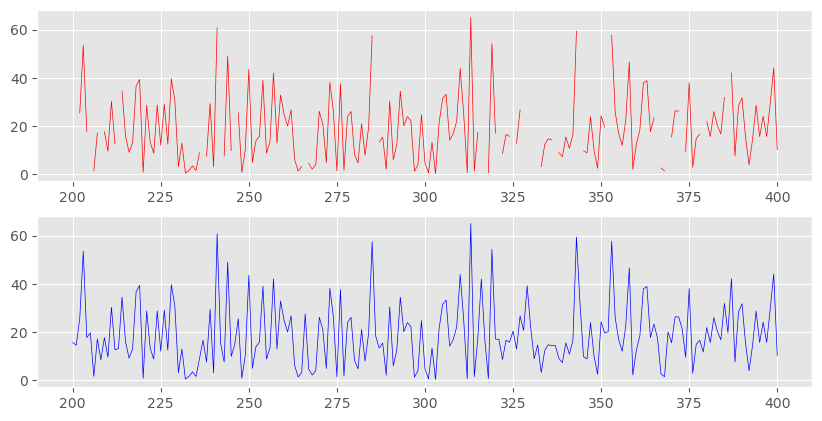

In [38]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')

fig = plt.figure(figsize=(10, 5), dpi=100)
ax1 = plt.subplot(2, 1, 1) # 1行1列目
ax2 = plt.subplot(2, 1, 2) # 1行2列目
ax1.plot(df.loc[200:400].index, df.loc[200:400]['thickness'], linewidth=0.5, color='red')
ax2.plot(df2.loc[200:400].index, df2.loc[200:400]['thickness'], linewidth=0.5, color='blue')

In [46]:
!pip install statsmodels

In [47]:
df

,length,thickness,type_B,type_C,type_D,type_E,fault_flg_True
0,274.027383,40.241131,0,0,0,1,0
1,86.319269,16.906715,0,0,1,0,0
2,123.940388,1.018462,0,0,0,1,0
3,175.554886,16.414924,1,0,0,0,0
4,244.934740,29.061081,1,0,0,0,0
...,...,...,...,...,...,...,...
995,363.214163,48.369483,0,1,0,0,0
996,134.773797,26.861665,0,0,1,0,0
997,231.174985,7.087471,1,0,0,0,0
998,81.613510,5.716271,0,0,1,0,0


#### statsmodelsも使ってみたがよくわからんかった...

In [48]:
from statsmodels.imputation import mice
import statsmodels.api as sm

imp = mice.MICEData(df)
fml = "thickness ~ length + type_B + type_C + type_D + type_E + fault_flg_True"
mice_ = mice.MICE(fml, sm.OLS, imp)
results = mice_.fit(10,10)
print(results.summary())

                           Results: MICE
Method:                  MICE           Sample size:          1000  
Model:                   OLS            Scale                 157.11
Dependent variable:      thickness      Num. imputations      10    
--------------------------------------------------------------------
                Coef.  Std.Err.    t    P>|t|   [0.025 0.975]  FMI  
--------------------------------------------------------------------
Intercept       1.5476   1.4156  1.0933 0.2743 -1.2269 4.3222 0.0695
length          0.0915   0.0074 12.3705 0.0000  0.0770 0.1060 0.1062
type_B          0.3329   1.4385  0.2314 0.8170 -2.4866 3.1524 0.1127
type_C         -0.8485   1.7731 -0.4786 0.6323 -4.3236 2.6266 0.1047
type_D         -0.7171   1.2592 -0.5695 0.5690 -3.1851 1.7508 0.0475
type_E         -0.1643   1.3345 -0.1231 0.9020 -2.7799 2.4513 0.0483
fault_flg_True -0.8825   1.8946 -0.4658 0.6413 -4.5958 2.8308 0.0316

